### **Stock Market Prediction And Forecasting Using Stacked LSTM**

In [75]:
### Data Collection
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import numpy
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
key="65a26fb56bb29df8cc306d7cb0980a97a3c56063"

df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('AAPL.csv')
df=pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-05-02 00:00:00+00:00,93.64,94.08,92.40,93.965,48160104,21.770058,21.872352,21.481774,21.845616,192640416,0.00,1.0
1,AAPL,2016-05-03 00:00:00+00:00,95.18,95.74,93.68,94.200,56831277,22.128088,22.258280,21.779357,21.900251,227325108,0.00,1.0
2,AAPL,2016-05-04 00:00:00+00:00,94.19,95.90,93.82,95.200,41025475,21.897926,22.295478,21.811906,22.132737,164101900,0.00,1.0
3,AAPL,2016-05-05 00:00:00+00:00,93.24,94.07,92.68,94.000,35890500,21.809581,22.003724,21.678592,21.987351,143562000,0.57,1.0
4,AAPL,2016-05-06 00:00:00+00:00,92.72,93.45,91.85,93.370,43699886,21.687949,21.858701,21.484449,21.839989,174799544,0.00,1.0


Text(0.5, 0, 'Time Step')

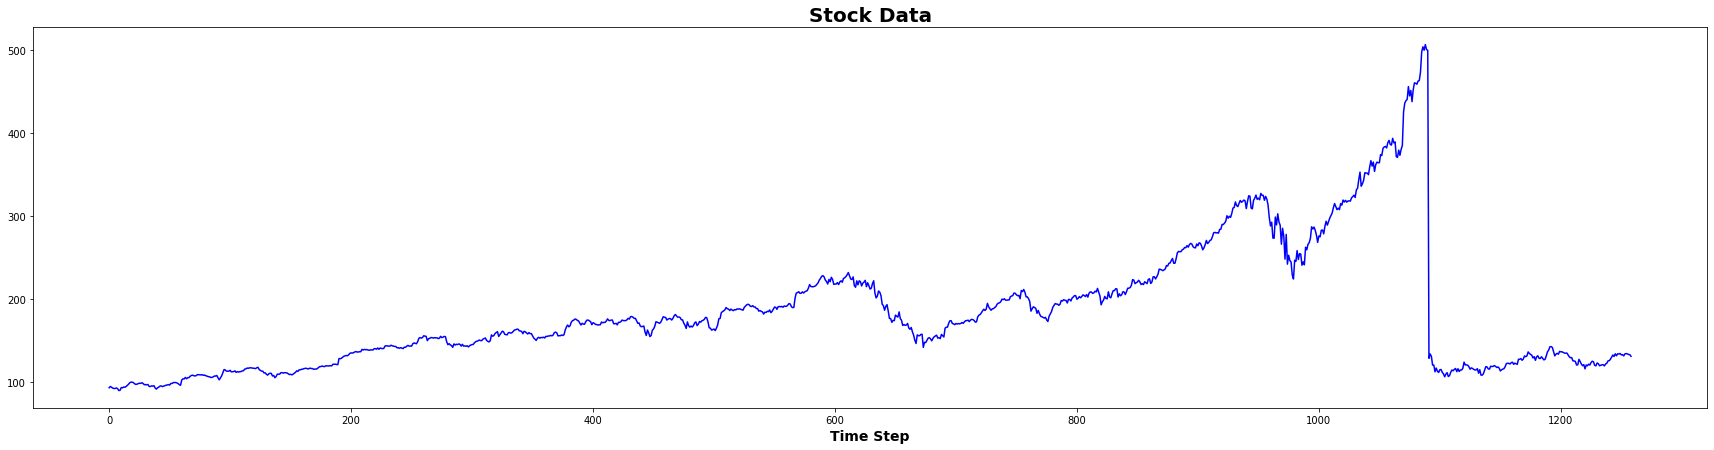

In [76]:
df1=df.reset_index()['close']
fig, axs = plt.subplots(figsize=(30,7))
axs.plot(df1,'blue')
axs.set_title('Stock Data',fontsize=20,fontweight='bold')
axs.set_xlabel('Time Step',fontsize=14,fontweight='bold')

### **LSTM are sensitive to the scale of the data. So we apply MinMax scaler**

In [78]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]
training_size,test_size

# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)
 
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(ytest.shape)

# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

(717, 100)
(717,)
(340, 100)
(340,)


In [79]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 8s 289ms/step - loss: 0.0146 - val_loss: 0.0436
Epoch 2/100
12/12 [==============================] - 2s 198ms/step - loss: 0.0020 - val_loss: 0.0240
Epoch 3/100
12/12 [==============================] - 2s 198ms/step - loss: 8.1540e-04 - val_loss: 0.0199
Epoch 4/100
12/12 [==============================] - 2s 200ms/step - loss: 5.2896e-04 - val_loss: 0.0189
Epoch 5/100
12/12 [==============================] - 2s 200ms/step - loss: 4.1844e-04 - val_loss: 0.0186
Epoch 6/100
12/12 [==============================] - 2s 201ms/step - loss: 3.9024e-04 - val_loss: 0.0181
Epoch 7/100
12/12 [==============================] - 2s 200ms/step - loss: 3.7227e-04 - val_loss: 0.0177
Epoch 8/100
12/12 [==============================] - 2s 202ms/step - loss: 3.3538e-04 - val_loss: 0.0174
Epoch 9/100
12/12 [==============================] - 2s 203ms/step - loss: 3.7728e-04 - val_loss: 0.0171
Epoch 10/100
12/12 [==============================] - 2s 202ms/

### **Lets Do the prediction and check performance metrics**

In [81]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

### **Transform back to original form**

In [82]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### **Calculate RMSE performance metrics**

In [83]:
math.sqrt(mean_squared_error(y_train,train_predict))

170.23706015787695

### **Test Data RMSE**

In [84]:
math.sqrt(mean_squared_error(ytest,test_predict))

237.6565509715008

### **Plotting our Model** 

Text(0.5, 0, 'Time Step')

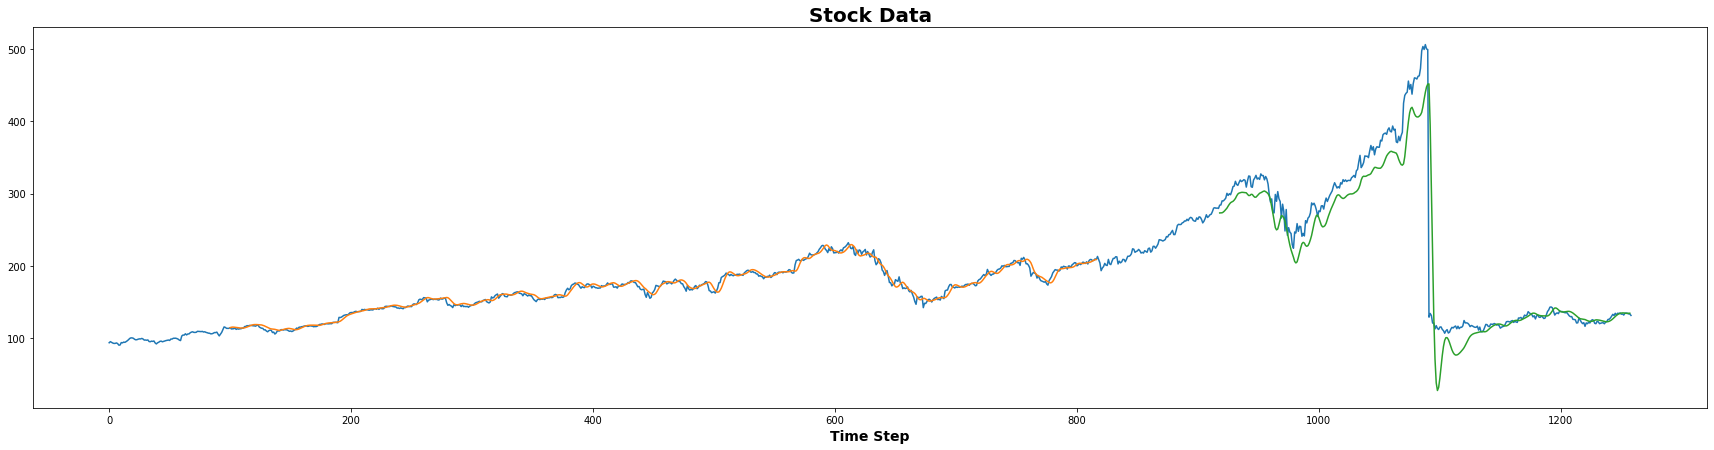

In [91]:
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions

fig, axs = plt.subplots(figsize=(30,7))
axs.plot(scaler.inverse_transform(df1))
axs.plot(trainPredictPlot)
axs.plot(testPredictPlot)
axs.set_title('Stock Data',fontsize=20,fontweight='bold')
axs.set_xlabel('Time Step',fontsize=14,fontweight='bold')

In [86]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [87]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.10642654]
101
1 day input [0.08187613 0.07562237 0.0791341  0.0771377  0.07562237 0.09029465
 0.09012628 0.09226699 0.08734817 0.0911365  0.09991581 0.09770295
 0.10013229 0.11148527 0.10710764 0.10434155 0.1018641  0.09397474
 0.09782321 0.08721587 0.09760673 0.10032471 0.09294047 0.09250752
 0.09753458 0.0927721  0.08851473 0.09017438 0.10027661 0.11191822
 0.11720986 0.12647023 0.1270475  0.12440168 0.11244738 0.10010824
 0.10535177 0.10739627 0.10487072 0.11316897 0.11165364 0.11201443
 0.10984967 0.10835839 0.10773301 0.10831028 0.10306675 0.09741431
 0.09469633 0.09508118 0.0857727  0.08543596 0.08420926 0.07372219
 0.07437162 0.09007817 0.08365604 0.07629585 0.07165364 0.07475646
 0.06258569 0.07395069 0.07129284 0.07605532 0.0738184  0.08093806
 0.08473842 0.08279014 0.07261575 0.0713169  0.07949489 0.07745039
 0.07155743 0.07276007 0.07425135 0.07468431 0.07110042 0.07651233
 0.07855683 0.08553217 0.08627781 0.09034275 0.09625977 0.10259771
 0.09837643 0.10604931 0.10027661

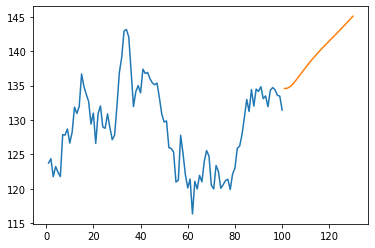

In [96]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
plt.plot(day_new,scaler.inverse_transform(df1[1159:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

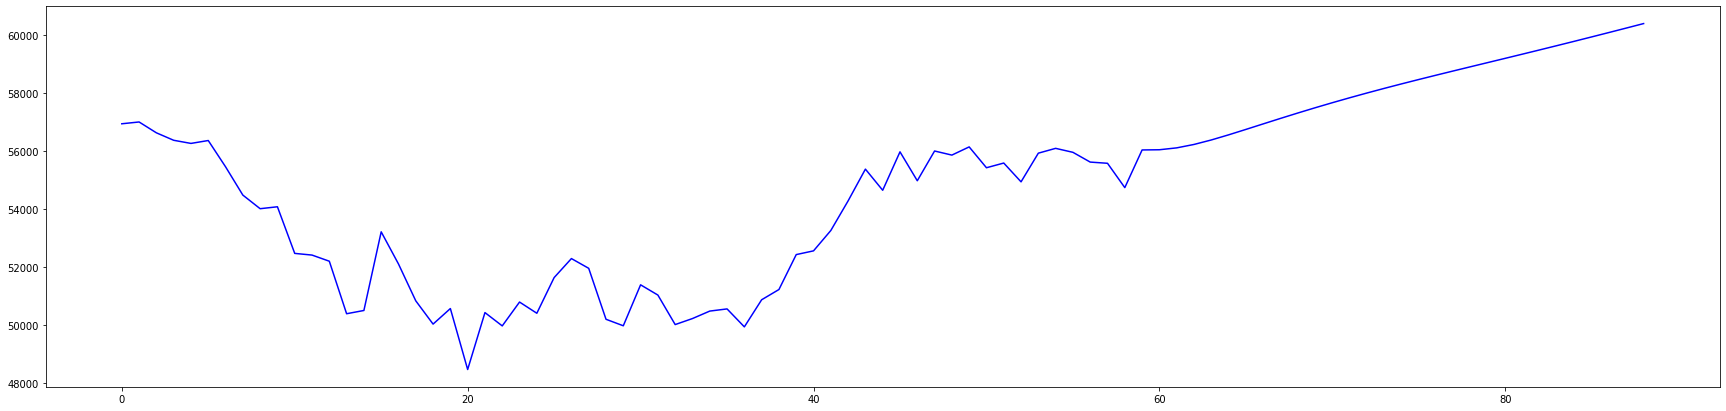

In [100]:
fig, axs = plt.subplots(figsize=(30,7))
axs.plot(df3[1200:],'b')

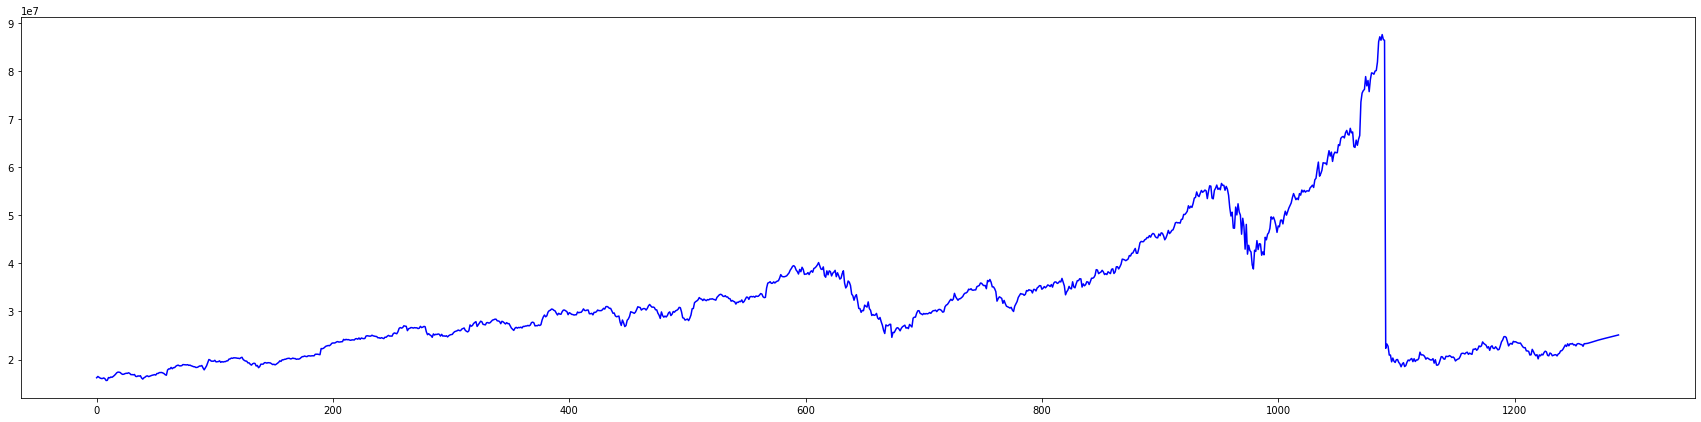

In [101]:
df3=scaler.inverse_transform(df3).tolist()
fig, axs = plt.subplots(figsize=(30,7))
axs.plot(df3,'b')